# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto

- Descarga los datos y haz el remuestreo por una hora.
- Analiza los datos
- Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.
- Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

- Los datos se almacenan en el archivo `taxi.csv`. 	
- El número de pedidos está en la columna `num_orders`.

## Preprocesamiento de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates = True, index_col = 'datetime')

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.duplicated().sum()

26415

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


### Primeras observaciones frente a la base de datos:

Tras un sondeo rápido podemos observar que no hay datos ausentes, ni duplicados (estos se mostraron tras hacer cambios en la columna datetime), pero si nos encontramos con que la columna datetime no está en el tipo adecuado. Se hará el cambio desde la segunda línea de código. 

Además, podemos observar que los intervalos de tiempo están a 10 minutos. 


## Análisis de los datos

In [6]:
# Revisión del orden de los datos. 

df.sort_index(inplace=True)

print(df.index.is_monotonic)

True


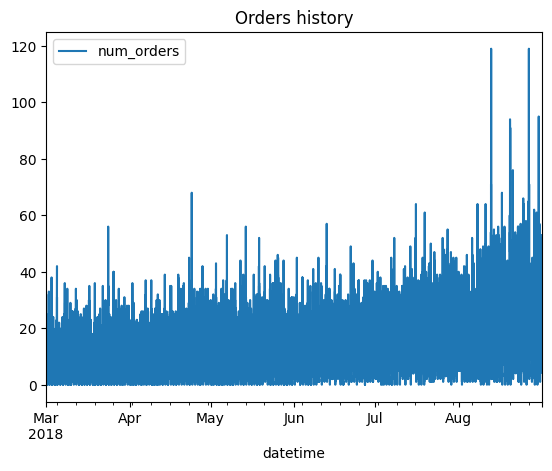

In [7]:
df.plot()
plt.title('Orders history')
plt.show()

In [8]:
# Remuestreo por hora: 

df = df.resample('1H').sum()

df.sample(5)

,num_orders
datetime,
2018-06-27 04:00:00,121
2018-05-13 17:00:00,117
2018-07-03 00:00:00,149
2018-03-09 23:00:00,49
2018-06-23 03:00:00,126


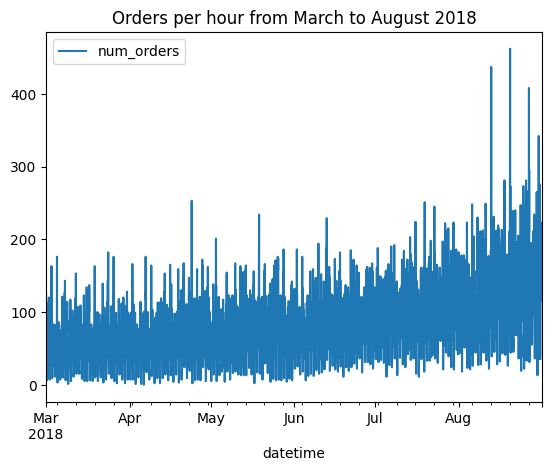

In [9]:
df.plot()
plt.title('Orders per hour from March to August 2018')
plt.show()

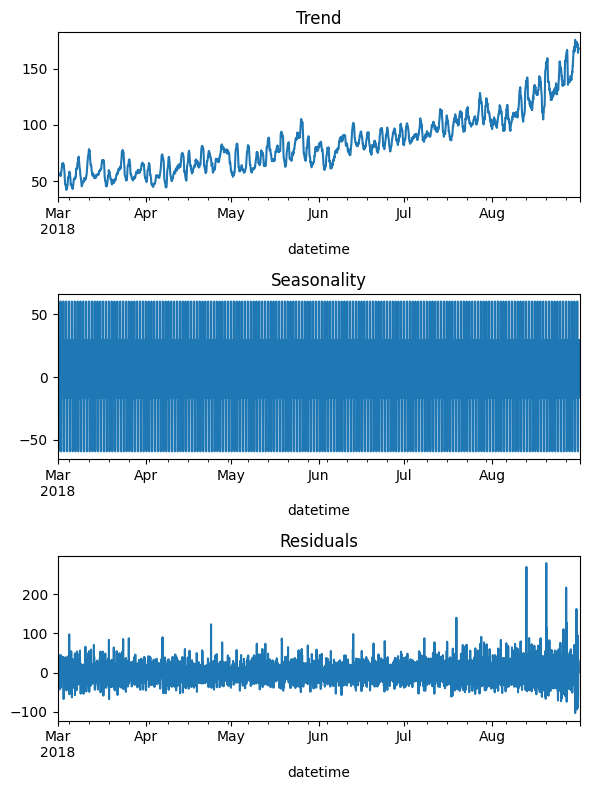

In [10]:
decomposed = seasonal_decompose(df)

plt.figure(figsize = (6, 8))

plt.subplot(311)
decomposed.trend.plot(ax = plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax = plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax = plt.gca())
plt.title('Residuals')

plt.tight_layout()

In [11]:
# Creación de características adicionales:

def new_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

new_features(df, 30, 60)

print(df.head())

                     num_orders  year  month  day  dayofweek  hour  lag_1  \
datetime                                                                    
2018-03-01 00:00:00         124  2018      3    1          3     0    NaN   
2018-03-01 01:00:00          85  2018      3    1          3     1  124.0   
2018-03-01 02:00:00          71  2018      3    1          3     2   85.0   
2018-03-01 03:00:00          66  2018      3    1          3     3   71.0   
2018-03-01 04:00:00          43  2018      3    1          3     4   66.0   

                     lag_2  lag_3  lag_4  ...  lag_22  lag_23  lag_24  lag_25  \
datetime                                  ...                                   
2018-03-01 00:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 01:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 02:00:00  124.0    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 03:00:00   85.0  124.0    NaN  ...     NaN  

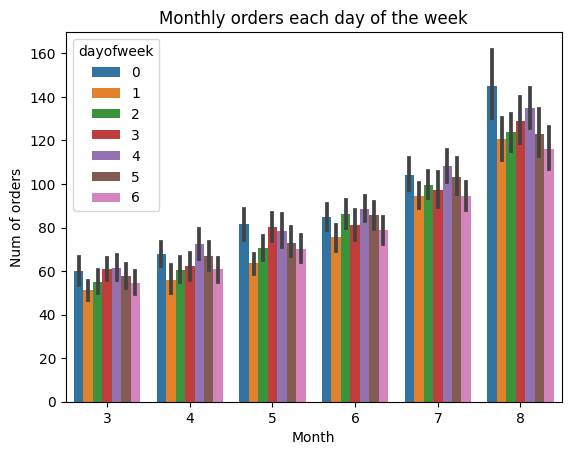

In [12]:
sns.barplot(data = df, x = 'month', hue = 'dayofweek', y = 'num_orders')

plt.title('Monthly orders each day of the week')
plt.xlabel('Month')
plt.ylabel('Num of orders')
plt.show()

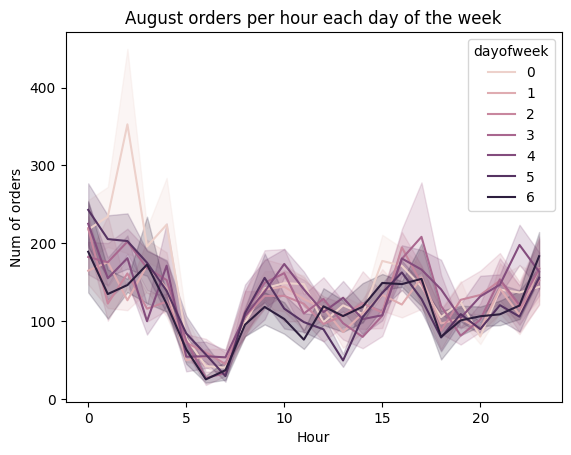

In [13]:
data_aug =  df[df['month'] == 8]

sns.lineplot(data = data_aug, x = 'hour', y = 'num_orders', hue = 'dayofweek')

plt.title('August orders per hour each day of the week')
plt.xlabel('Hour')
plt.ylabel('Num of orders')
plt.show()

### Conclusiones del análisis de los datos:

A partir de las gráficas se puede concluir lo siguiente: 
- Los datos históricos de los servicios solicitados a Sweet Lift Taxi desde el aeropuerto tienen una tendencia al alza.
- No se tienen los suficientes datos para identificar patrones estacionales de los servicios solicitados, ya que los datos van de marzo a agosto. 
- El mes con mayor cantidad de pedidos es agosto, sin importar el día de la semana, los pedidos de este mes superan a los de cualquier otro. 
- De los pedidos hechos a Sweet Lift Taxi, el histórico de los servicios solicitados en el mes de agosto demuestra que la menor cantidad de pedidos se dan entre las 5 a.m. y las 7 a.m. sin importar que día de la semana sea; mientras que hay un pico de pedidos en la madrugada de los lunes entre 12 y 3 a.m.

## Entrenamiento

In [14]:
# División de los datos:

train, test = train_test_split(df, shuffle = False, test_size = 0.2)

test, valid = train_test_split(test, shuffle = False, test_size = 0.5)

train = train.dropna()


In [15]:
print(train.shape)
print(test.shape)
print(valid.shape)

(3472, 37)
(442, 37)
(442, 37)


In [16]:
# Datos para el entrenamiento, validación y la prueba:

features_train = train.drop(['num_orders', 'year', 'month', 'day', 'dayofweek', 'hour'], axis = 1)
target_train = train['num_orders']

features_test = test.drop(['num_orders', 'year', 'month', 'day', 'dayofweek', 'hour'], axis = 1)
target_test = test['num_orders']

features_valid = valid.drop(['num_orders', 'year', 'month', 'day', 'dayofweek', 'hour'], axis = 1)
target_valid = valid['num_orders']

In [17]:
# Elección de paramétros para Bosque aleatorio

best_error = 10000 

best_est = 0

best_depth = 0

for est in range(10, 51, 10):
    for depth in range (1, 11):
        model_rf = RandomForestRegressor(random_state = 66, n_estimators = est, max_depth = depth)
        model_rf.fit(features_train, target_train)
        pred_valid = model_rf.predict(features_valid)
        RECM_valid_rf = mean_squared_error(target_valid, pred_valid) ** 0.5

        if RECM_valid_rf < best_error:
            best_error = RECM_valid_rf
            best_est = est
            best_depth = depth

print("RECM del mejor modelo en el conjunto de validación:", best_error, 
      "n_estimators:", best_est, "best_depth:", best_depth)

RECM del mejor modelo en el conjunto de validación: 51.32128480237241 n_estimators: 50 best_depth: 10


El modelo número 1 de Bosque aleatorio sobrepasó la RECM propuesta en el ejercicio, es por ello que se descarta el modelo para implementarse en el conjunto de prueba. 

In [19]:
# Elección de parámetros para Árbol de dicisión

best_model = None

best_result = 10000

best_depth = 0

for depth in range(1, 20): 
    model_dt = DecisionTreeRegressor(max_depth = depth, random_state = 66) 
    model_dt.fit(features_train, target_train)
    pred_valid = model_dt.predict(features_valid)
    RECM_valid_dt = mean_squared_error(target_valid, pred_valid) ** 0.5
    
    if RECM_valid_dt < best_result:
        best_model = model_dt
        best_result = RECM_valid_dt
        best_depth = depth

print(f"RECM del mejor modelo en el conjunto de validación es (max_depth = {best_depth}): {best_result}")

RECM del mejor modelo en el conjunto de validación es (max_depth = 7): 54.802693422346366


El modelo número 2 de Árbol de decisión sobrepasó la RECM propuesta en el ejercicio, es por ello que se descarta el modelo para implementarse en el conjunto de prueba. 

In [21]:
# Modelo 3: Regresión lineal

model_lr = LinearRegression()

model_lr.fit(features_train, target_train)

pred_valid_lr = model_lr.predict(features_valid)

RECM_valid_lr = mean_squared_error(target_valid, pred_valid_lr) ** 0.5

print("RECM para el conjunto de validación:", (RECM_valid_lr).round(2))

RECM para el conjunto de validación: 45.17


El modelo 3 de Regresión Lineal es el único que cumplió con la RECM de 48, así que se procederá a implementar el modelo en el conjunto de datos de prueba. 

In [22]:
# Modelo Nº 3 implementado en el conjunto de prueba. 

pred_test_lr = model_lr.predict(features_test)

RECM_test_lr = mean_squared_error(target_test, pred_test_lr) ** 0.5

print("RECM para el conjunto de prueba:", (RECM_test_lr).round(2))

RECM para el conjunto de prueba: 33.86


In [23]:
# Refuerzo de gradiente con LightGBM

train_data = lgb.Dataset(features_train, label = target_train)

test_data = lgb.Dataset(features_test, label = target_test, reference = train_data)

params = {
    "objective": 'regression',
    "boosting": 'rf',
    "num_leaves": 31,
    "learning_rate": 0.1,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "seed": 23,
    "force_col_wise":True,
}

gbm = lgb.train(params, train_data, num_boost_round = 20, valid_sets = test_data, 
                callbacks = [lgb.early_stopping(stopping_rounds = 5)])

predictions_lgb = gbm.predict(features_test, num_iteration = gbm.best_iteration)

RECM_test_lgb = mean_squared_error(target_test, predictions_lgb) ** 0.5

print(f"RECM para el conjunto de prueba: {RECM_test_lgb}")



[LightGBM] [Info] Total Bins 5524
[LightGBM] [Info] Number of data points in the train set: 3472, number of used features: 31
[LightGBM] [Info] Start training from score 74.568260
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[19]	valid_0's l2: 1345.15
RECM para el conjunto de prueba: 36.676318756417


El refuerzo de gradiente con los parámetros estipulados no logró mejorar la RECM del modelo Nº 3 en el conjunto de prueba, por lo cual se descarta como propuesta para la compañía Sweet Lift Taxi.

## Conclusiones

In [31]:
results_table = pd.DataFrame({'Model':['Random Forest Regressor', 'Decision Tree Regressor', 'Linear Regression', 'LightGBM'],
                              'RECM validation':[best_error, best_result, RECM_valid_lr, ''], 
                             'RECM test':['', '', RECM_test_lr, RECM_test_lgb]})

results_table


,Model,RECM validation,RECM test
0,Random Forest Regressor,51.321285,
1,Decision Tree Regressor,54.802693,
2,Linear Regression,45.174953,33.857419
3,LightGBM,,36.676319


Tras ejecutar tres modelos y un método de refuerzo de gradiente podemos concluir:
- El único modelo que cumplió con la métrica de RECM cuando se puso a prueba en el conjunto de validación fue el modelo de Regresión Lineal.
- El modelo con una RECM más baja, y por ende, más adecuado para su implementación en la compañía Sweet Lift Taxi es el **modelo número 3 de Regresión Lineal, con una RECM de tan solo 33.85 horas.**
- Si bien el refuerzo de gradiente aplicado cumplió la métrica de RECM del ejercicio, los resultados de los parámetros no lograron superar la RECM del modelo de Regresión Lineal por sí solo. 